# HaptiGlow

This notebook shows a worked example of how data from a real experiment can be analysed using a repeated measures ANOVA test. The data used here comes from the [HaptiGlow](http://euanfreeman.co.uk/haptiglow/) project, which investigated interaction techniques for helping users position their hand above a mid-air gesture system. Hand position is important for mid-air interaction, because it affects input sensing quality and mid-air haptic feedback quality (in this case, the quality of ultrasound haptic feedback).

## Experiment design

This was a within-subjects experiment with three conditions: _Haptics_, _Lights_ and _Haptics+Lights_. Each condition represents a feedback technique. Our experimental task was to use the feedback from our device to locate a target point in mid-air as quickly and as accurately as possible. We recorded two dependent variables for each task: task time, and distance between the hand and target point (hands were tracked using a Leap Motion sensor).

## Experiment data

First, lets look at the experiment data:

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import seaborn as sns

# Read experiment data into a data frame
data = pd.read_csv("haptiglow.csv")

# Get rid of excess columns - we don't need these for this analysis
data = data.drop(columns=["Block", "Condition", "Task", "XDiff", "YDiff", "ZDiff"])

# Show the first lines in the data frame, to demonstrate format
print(data.head(10))

   Participant   ConditionName      Time  Distance
0            1  Haptics+Lights   8659.81  14.85520
1            1  Haptics+Lights   7261.66  20.75210
2            1  Haptics+Lights  13118.40   6.55584
3            1  Haptics+Lights  13341.80  23.72940
4            1  Haptics+Lights   8432.94  28.44560
5            1  Haptics+Lights  14013.00  36.80310
6            1  Haptics+Lights   7966.66  31.95510
7            1  Haptics+Lights  13421.40  57.19450
8            1  Haptics+Lights   7705.22  48.96180
9            1  Haptics+Lights  12682.40  62.92290


Our final data frame has an individual row for every experiment task, with four columns:

1. `Participant`: the grouping variable in our within-subject experiment;
2. `ConditionName`: our independent variable;
3. `Time`: task time (in ms);
4. `Distance`: distance from target point (in mm);

In the experiment, participants completed several tasks for each condition. This is an important part of the experiment design. We gathered repeated measurements for each condition -- in other words, we increased our sample size, in order to obtain a more accurate estimation of the true mean. We thus have multiple values for each condition and must first aggregate the data to obtain the mean for every `Participant` x `Condition` combination.

## Aggregating data

We can aggregate data using the `groupby` and `agg` functions. In the following statement, we tell `pandas` to group our data using two variables (`Participant` and `ConditionName`), then apply an aggregation function to the resulting `Time` and `Distance` columns.

In [9]:
data = data.groupby(['Participant', 'ConditionName'], as_index=False).agg({'Time': 'mean', 'Distance': 'mean'})

print(data.head(10))

   Participant   ConditionName         Time   Distance
0            1         Haptics  7977.012105  35.661357
1            1  Haptics+Lights  7815.362647  22.924149
2            1          Lights  9942.641724  27.628548
3            2         Haptics  3811.206500  29.525847
4            2  Haptics+Lights  2876.416500  20.395449
5            2          Lights  5100.147436  34.759897
6            3         Haptics  6203.199500  39.062138
7            3  Haptics+Lights  4212.741250  14.598959
8            3          Lights  6405.068056  33.140594
9            4         Haptics  4898.799737  34.945939


Note that we now have a single row for each combination of `Participant` x `ConditionName`.

## Plotting data

The following plot shows the distribution of task times and distances from this experiment:

Text(0, 0.5, 'Density')

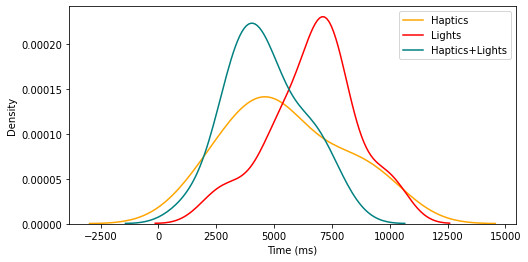

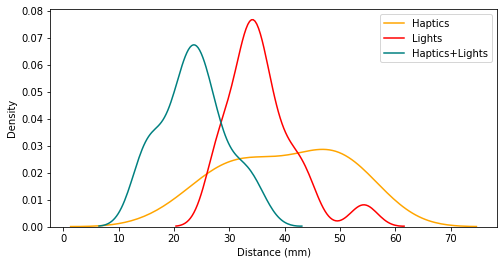

In [3]:
h  = data.loc[data['ConditionName'] == 'Haptics']
l  = data.loc[data['ConditionName'] == 'Lights']
hl = data.loc[data['ConditionName'] == 'Haptics+Lights']

plot, axis = plt.subplots(figsize=(8, 4))
sns.distplot(h['Time'],  hist=False, label="Haptics",        color="orange")
sns.distplot(l['Time'],  hist=False, label="Lights",         color="red")
sns.distplot(hl['Time'], hist=False, label="Haptics+Lights", color="teal")
axis.set_xlabel("Time (ms)")
axis.set_ylabel("Density")

plot, axis = plt.subplots(figsize=(8, 4))
sns.distplot(h['Distance'],  hist=False, label="Haptics",        color="orange")
sns.distplot(l['Distance'],  hist=False, label="Lights",         color="red")
sns.distplot(hl['Distance'], hist=False, label="Haptics+Lights", color="teal")
axis.set_xlabel("Distance (mm)")
axis.set_ylabel("Density")

From a quick glance at these plots, some trends begin to emerge. _Lights_ appears to have slightly longer task times than the other two conditions. There is also a wider spread of task times for the _Haptics_ condition, revealed by its wider distribution (therefore giving it a lower peak).

We can also see that _Haptics+Lights_ leads the lowest `Distance` values (i.e., users were more accurate in this condition). As before, there is also a much wider spread for the _Haptics_ condition.

However, as you know, this is insufficient evidence for us to draw conclusions. We need empirical evidence that there is, indeed, likely to be a distance between these conditions.

## ANOVA

Using the `rm_anova` function from `pingouin`, we can perform a repeated measures ANOVA on our experiment data. In the function call, we identify our _dependent variable_, our _independent variable_, and the `Participant` column as the variable by which our measurements are repeated.

In [11]:
aov_time = pg.rm_anova(dv='Time', within='ConditionName', subject='Participant', data=data)
pg.print_table(aov_time)


ANOVA SUMMARY

Source           ddof1    ddof2       F    p-unc    p-GG-corr    np2    eps  sphericity      W-spher    p-spher
-------------  -------  -------  ------  -------  -----------  -----  -----  ------------  ---------  ---------
ConditionName        2       38  17.880    0.000        0.000  0.485  0.717  False             0.605      0.011



In [12]:
aov_dist = pg.rm_anova(dv='Distance', within='ConditionName', subject='Participant', data=data)
pg.print_table(aov_dist)


ANOVA SUMMARY

Source           ddof1    ddof2       F    p-unc    np2    eps
-------------  -------  -------  ------  -------  -----  -----
ConditionName        2       38  36.862    0.000  0.660  0.784



A repeated measures ANOVA found a significant main effect of condition on task time: $F(2, 38) = 17.88, p < 0.001$.

A repeated measures ANOVA found a significant main effect of condition on error distance: $F(2, 38) = 36.86, p < 0.001$.

Note that the output from these tests is slightly different, as the task time data required sphericity correction (don't worry about what this means, for now).

### Post hoc pairwise comparisons

Both ANOVA tests found a significant main effect of experimental condition. In other words, experimental condition is likely the cause of variance in both task time and error distance. Recall from before that this is insufficient to tell us _what_ the significant differences are - therefore, post hoc tests are required.

In this instance, we need to perform multiple pairwise comparisons between all of our experiment conditions: i.e., three tests, comparing every unique pair. As we saw in the previous ANOVA example, the appropriate post hoc comparison is the t-test. We can use the `pairwise_ttests` function from `pingouin` to perform these comparisons for us.

### Task time

In [15]:
ph_time = pg.pairwise_ttests(dv='Time', within='ConditionName', subject='Participant', data=data)
pg.print_table(ph_time)


POST HOC TESTS

Contrast       A               B               Paired    Parametric         T     dof  Tail         p-unc       BF10    hedges
-------------  --------------  --------------  --------  ------------  ------  ------  ---------  -------  ---------  --------
ConditionName  Haptics         Haptics+Lights  True      True           3.031  19.000  two-sided    0.007      7.018     0.414
ConditionName  Haptics         Lights          True      True          -2.661  19.000  two-sided    0.015      3.579    -0.519
ConditionName  Haptics+Lights  Lights          True      True          -7.358  19.000  two-sided    0.000  30120.000    -1.141



* Task time was higher for _Haptics_ than _Haptics+Lights_: $t = 3.03, p = 0.007$
* Task time was lower for _Haptics_ than _Lights_: $t = -2.66, p = 0.02$
* Task time was lower for _Haptics+Lights_ than _Lights_: $t = -7.36, p < 0.001$

### Error distance

In [13]:
ph_dist = pg.pairwise_ttests(dv='Distance', within='ConditionName', subject='Participant', data=data)
pg.print_table(ph_dist)


POST HOC TESTS

Contrast       A               B               Paired    Parametric         T     dof  Tail         p-unc        BF10    hedges
-------------  --------------  --------------  --------  ------------  ------  ------  ---------  -------  ----------  --------
ConditionName  Haptics         Haptics+Lights  True      True           7.610  19.000  two-sided    0.000   47010.000     1.876
ConditionName  Haptics         Lights          True      True           1.817  19.000  two-sided    0.085       0.923     0.468
ConditionName  Haptics+Lights  Lights          True      True          -8.861  19.000  two-sided    0.000  386600.000    -1.977



* Error distance was higher for _Haptics_ than _Haptics+Lights_: $t = 7.61, p < 0.001$
* Error distance was lower for _Haptics+Lights_ than _Lights_: $t = -8.86, p < 0.001$
* There was no significiant difference between _Haptics_ and _Lights_: $t = 1.82, p = 0.09$

## Discussion

These results give insight into how the experimental condition (i.e., feedback technique) affected the time and accuracy in the target-location task. Error distance was significantly lower for _Haptics+Lights_ than the other conditions, and it also had significantly faster task times as well. From this, we can conclude that the _Haptics+Lights_ feedback technique was the best of the three we investigated in our experiment.

The statistical analysis demonstrated here supports the conclusion that _Haptics+Lights_ was the best performing feedback technique, when guiding a user's hand in mid-air. However, these results alone do not tell us _why_ it was the best performing technique. In other words, they do not tell us _why_ it led to faster task times or lower error distances. For us to be able to understand this, further work was required. I won't discuss this here, for brevity, but if you're interested then you can read [our paper from the 2019 IEEE World Haptics Conference](http://research.euanfreeman.co.uk/papers/WHC_2019.pdf) for more information.

Note that the numbers reported here vary slightly from those we reported in the paper. This is because the example given here uses a simpler, but still valid, analysis approach. However, the main results (i.e., the presence or absence of significant differences between the conditions) were the same.